<a href="https://colab.research.google.com/github/NethmiAmasha/Edge-Detection-with-Mamba/blob/main/EDMB_fromscratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab cell
import torch
print("cuda available:", torch.cuda.is_available())
print("torch:", torch.__version__)
print("cuda device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

cuda available: False
torch: 2.8.0+cu126
cuda device: None


In [2]:
pip install -q torch torchvision

In [3]:
pip install -q tqdm opencv-python matplotlib pillow scipy

In [4]:
pip install -q git+https://github.com/Dao-AILab/causal-conv1d@v1.1.1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.5/446.5 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 13.4 MB/s eta 0:00:00


High-resolution encoder (Eh)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HighResEncoder(nn.Module):
    """
    Minimal high-resolution encoder (Eh).
    Produces two feature maps:
      - f1: same spatial resolution as input (useful for edges)
      - f2: half resolution (downsampled)
    This is intentionally simple so you can read & understand every line.
    """
    def __init__(self, in_ch=3, base_ch=16):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(base_ch, base_ch*2, kernel_size=3, stride=2, padding=1),  # downsamples by 2
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True)
        )
        # small extra conv to produce a refined same-res feature from upsampled low-res
        self.refine = nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # x: (B,3,H,W)
        f1 = self.conv1(x)               # (B, base_ch, H, W)
        f2 = self.conv2(f1)              # (B, base_ch*2, H/2, W/2)
        # upsample f2 back to input resolution and refine
        f2_up = F.interpolate(f2, size=f1.shape[-2:], mode='bilinear', align_corners=False)
        f2_refined = self.refine(f2_up)  # (B, base_ch, H, W)
        # return a list of features consistent with paper notation [f1 (HR), f2 (down->HR)]
        return [f1, f2_refined]

# Quick shape test
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = HighResEncoder(in_ch=3, base_ch=16).to(device)
    x = torch.randn(2,3,320,320).to(device)   # batch of 2, 320x320 images
    feats = model(x)
    print("f1 shape:", feats[0].shape)
    print("f2_refined shape:", feats[1].shape)

f1 shape: torch.Size([2, 16, 320, 320])
f2_refined shape: torch.Size([2, 16, 320, 320])


Global Mamba Encoder (Eg) and Fine-grained Mamba Encoder (Ef)

In [6]:
# Simplified MIXENC (Global + Fine-grained encoders)
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNNEncoder(nn.Module):
    """A lightweight CNN that returns 3 feature maps at different scales."""
    def __init__(self, in_ch=3, base_ch=32):
        super().__init__()
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, 1, 1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )
        self.stage2 = nn.Sequential(
            nn.Conv2d(base_ch, base_ch*2, 3, 2, 1),  # downsample by 2
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True)
        )
        self.stage3 = nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch*4, 3, 2, 1),  # downsample by 4
            nn.BatchNorm2d(base_ch*4),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        f1 = self.stage1(x)  # (B, base_ch, H, W)
        f2 = self.stage2(f1) # (B, base_ch*2, H/2, W/2)
        f3 = self.stage3(f2) # (B, base_ch*4, H/4, W/4)
        return [f1, f2, f3]

class MIXENC_Light(nn.Module):
    """
    Simplified version of MIXENC (global + local encoders) for understanding.
    Mimics structure of Eg (global) + Ef (fine-grained).
    """
    def __init__(self, base_ch=32):
        super().__init__()
        self.global_encoder = SimpleCNNEncoder(in_ch=3, base_ch=base_ch)
        self.local_encoder = SimpleCNNEncoder(in_ch=3, base_ch=base_ch)

    def cat_patch(self, f00, f01, f10, f11, target_size):
        """Stitch 4 patches back together and resize to match global feature size."""
        top = torch.cat([f00, f01], dim=3)
        bottom = torch.cat([f10, f11], dim=3)
        combined = torch.cat([top, bottom], dim=2)
        combined = F.interpolate(combined, size=target_size, mode='bilinear', align_corners=False)
        return combined

    def forward(self, x):
        """
        Returns:
          global_feats: list of feature maps from global encoder
          local_feats: list of patch-fused feature maps
        """
        # 1️⃣ Global features
        global_feats = self.global_encoder(x)

        # 2️⃣ Prepare local patches
        _, _, H, W = x.shape
        x_up = F.interpolate(x, scale_factor=1.2, mode='bilinear', align_corners=False)
        _, _, H2, W2 = x_up.shape
        h_mid, w_mid = H2 // 2, W2 // 2

        patches = [
            x_up[..., :h_mid, :w_mid],   # top-left
            x_up[..., :h_mid, w_mid:],   # top-right
            x_up[..., h_mid:, :w_mid],   # bottom-left
            x_up[..., h_mid:, w_mid:]    # bottom-right
        ]

        # 3️⃣ Extract local features for each patch
        local_feats_per_patch = [self.local_encoder(p) for p in patches]  # list of 4 lists

        # 4️⃣ Merge patch features layer-wise
        local_feats = []
        for i in range(len(global_feats)):
            f00, f01, f10, f11 = local_feats_per_patch[0][i], local_feats_per_patch[1][i], local_feats_per_patch[2][i], local_feats_per_patch[3][i]
            merged = self.cat_patch(f00, f01, f10, f11, target_size=global_feats[i].shape[2:])
            local_feats.append(merged)

        return global_feats, local_feats

# 🔍 Test with random input
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MIXENC_Light(base_ch=32).to(device)
x = torch.randn(1, 3, 320, 320).to(device)

global_feats, local_feats = model(x)
for i, (g, l) in enumerate(zip(global_feats, local_feats)):
    print(f"Level {i+1}: global {g.shape}, local {l.shape}")

Level 1: global torch.Size([1, 32, 320, 320]), local torch.Size([1, 32, 320, 320])
Level 2: global torch.Size([1, 64, 160, 160]), local torch.Size([1, 64, 160, 160])
Level 3: global torch.Size([1, 128, 80, 80]), local torch.Size([1, 128, 80, 80])


In [7]:
# High-resolution encoder (Eh)
model_Eh = HighResEncoder(in_ch=3, base_ch=16).to(device)

# Combined Global + Fine-grained encoder (Eg + Ef)
model_MIX = MIXENC_Light(base_ch=32).to(device)

In [8]:
# Test both encoders and print feature shapes
with torch.no_grad():
    x = torch.randn(1, 3, 320, 320).to(device)
    f_high = model_Eh(x)
    g_global, g_local = model_MIX(x)

print("Eh outputs:")
for i, f in enumerate(f_high):
    print(f"  f{i+1}: {list(f.shape)}")

print("\nEg/Ef outputs (local_feats):")
for i, f in enumerate(g_local):
    print(f"  level{i+1}: {list(f.shape)}")

Eh outputs:
  f1: [1, 16, 320, 320]
  f2: [1, 16, 320, 320]

Eg/Ef outputs (local_feats):
  level1: [1, 32, 320, 320]
  level2: [1, 64, 160, 160]
  level3: [1, 128, 80, 80]


Learnable Gaussian Distribution Decoder

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LGDDecoder_Light(nn.Module):
    """
    Simplified Learnable Gaussian Distribution (LGD) decoder.
    Fuses high-res (Eh) and global (Eg/Ef) features.
    Outputs mu, sigma², and an auxiliary edge map.
    """
    def __init__(self, in_ch_high=16, in_ch_global=128, mid_ch=64):
        super().__init__()
        # 1️⃣ Fuse features from Eh and Eg/Ef
        self.fuse = nn.Sequential(
            nn.Conv2d(in_ch_high + in_ch_global, mid_ch, 3, padding=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, mid_ch, 3, padding=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True)
        )
        # 2️⃣ Output heads
        self.mu_head = nn.Conv2d(mid_ch, 1, kernel_size=1)      # mean
        self.var_head = nn.Sequential(                          # variance (>=0)
            nn.Conv2d(mid_ch, 1, kernel_size=1),
            nn.Softplus()
        )
        self.edge_head = nn.Conv2d(mid_ch, 1, kernel_size=1)    # auxiliary edge map

    def forward(self, f_high, f_global):
        # Upsample global feature to match high-res size
        f_global_up = F.interpolate(f_global, size=f_high.shape[-2:], mode='bilinear', align_corners=False)
        fused = torch.cat([f_high, f_global_up], dim=1)
        x = self.fuse(fused)
        mu = self.mu_head(x)
        sigma2 = self.var_head(x)
        edge_logits = self.edge_head(x)
        return mu, sigma2, edge_logits

# 🔍 Test with random features
device = "cuda" if torch.cuda.is_available() else "cpu"
decoder = LGDDecoder_Light(in_ch_high=16, in_ch_global=128, mid_ch=64).to(device)

# fake inputs from your encoders
f_high = torch.randn(1, 16, 320, 320).to(device)
f_global = torch.randn(1, 128, 80, 80).to(device)

mu, sigma2, edge_logits = decoder(f_high, f_global)
print("mu:", mu.shape, "sigma2:", sigma2.shape, "edge_logits:", edge_logits.shape)
print("sigma2 min/max:", sigma2.min().item(), sigma2.max().item())

mu: torch.Size([1, 1, 320, 320]) sigma2: torch.Size([1, 1, 320, 320]) edge_logits: torch.Size([1, 1, 320, 320])
sigma2 min/max: 0.155308797955513 1.8135780096054077


Loss Function

In [10]:
import torch
import torch.nn.functional as F

def elbo_loss(mu, sigma2, y, phi=1.0, lambda_pos=1.1):
    """
    mu, sigma2 : model outputs, shape [B,1,H,W]
    y          : ground truth edges (0/1), same shape
    phi        : weight for KL term
    lambda_pos : positive class weight (for edge pixels)
    """
    # --- Sample from Gaussian N(mu, sigma2)
    eps = torch.randn_like(mu)
    p = mu + eps * torch.sqrt(sigma2 + 1e-6)  # reparam trick
    p = torch.sigmoid(p)  # edge probability 0-1

    # --- Weighted BCE
    pos = (y == 1).float()
    neg = (y == 0).float()
    total = y.numel()
    pos_count = pos.sum().clamp_min(1.0)
    neg_count = neg.sum().clamp_min(1.0)
    alpha = pos_count / total
    beta = lambda_pos * (neg_count / total)
    wce = -(alpha * (pos * torch.log(p + 1e-8)).sum() +
            beta * (neg * torch.log(1 - p + 1e-8)).sum()) / total

    # --- KL divergence  D_KL(N(μ,σ²) || N(0,1))
    kl = 0.5 * ((mu ** 2 + sigma2 - torch.log(sigma2 + 1e-8) - 1).sum()) / total

    elbo = wce + phi * kl
    return elbo, wce, kl

In [11]:
# Fake outputs and ground truth
mu = torch.randn(1, 1, 320, 320)
sigma2 = torch.abs(torch.randn(1, 1, 320, 320))  # positive
y = (torch.rand(1, 1, 320, 320) > 0.8).float()   # random binary mask

elbo, wce, kl = elbo_loss(mu, sigma2, y)
print(f"ELBO: {elbo.item():.5f} | WCE: {wce.item():.5f} | KL: {kl.item():.5f}")

ELBO: 1.37828 | WCE: 0.66041 | KL: 0.71788


Checking with a fake batch

In [12]:
# End-to-end forward + ELBO test (use the models you built earlier)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# ensure these variables exist in your notebook:
# model_Eh, model_MIX, decoder (LGDDecoder_Light), and elbo_loss function

# Put models in train mode so gradients exist (we'll do a backward check)
model_Eh.train()
model_MIX.train()
decoder.train()

# Create a small fake batch
B = 2
x = torch.randn(B, 3, 320, 320).to(device)
# fake ground truth edges: sparse random edges
y = (torch.rand(B, 1, 320, 320) > 0.95).float().to(device)

# Forward: encoders
f_high = model_Eh(x)            # list [f1, f2_refined]  (both 320x320)
g_global, g_local = model_MIX(x)  # g_local is list of multi-scale fused local features

# Choose which global feature to feed to decoder:
# we used level3 (deepest) earlier: g_local[-1] or g_global[-1]
f_global_for_decoder = g_local[-1]  # shape [B, 128, 80, 80]

# Use f_high[1] (refined high-res) as the high-res input (same as earlier tests)
f_high_for_decoder = f_high[1]     # shape [B, 16, 320, 320]

# Decoder forward
mu, sigma2, edge_logits = decoder(f_high_for_decoder, f_global_for_decoder)

# Compute ELBO (phi=1.0)
elbo, wce, kl = elbo_loss(mu, sigma2, y, phi=1.0, lambda_pos=1.1)

print("Shapes:")
print(" x:", x.shape)
print(" f_high:", [tuple(t.shape) for t in f_high])
print(" g_local:", [tuple(t.shape) for t in g_local])
print(" mu:", mu.shape, "sigma2:", sigma2.shape, "edge_logits:", edge_logits.shape)
print()
print(f"ELBO: {elbo.item():.5f} | WCE: {wce.item():.5f} | KL: {kl.item():.5f}")

# Backward check: gradients should flow to decoder parameters (not to frozen global encoder if frozen)
elbo.backward()
print()
print("Gradients (sample):")
for name, p in list(decoder.named_parameters())[:6]:
    if p.grad is None:
        print(f"  {name}: grad None")
    else:
        print(f"  {name}: grad mean {p.grad.mean().item():.6e}, std {p.grad.std().item():.6e}")
# also check one param in model_Eh to see grad exists
for name, p in model_Eh.named_parameters():
    print(f"Eh param {name}: requires_grad={p.requires_grad}, grad is {'present' if p.grad is not None else 'None'}")
    break

Shapes:
 x: torch.Size([2, 3, 320, 320])
 f_high: [(2, 16, 320, 320), (2, 16, 320, 320)]
 g_local: [(2, 32, 320, 320), (2, 64, 160, 160), (2, 128, 80, 80)]
 mu: torch.Size([2, 1, 320, 320]) sigma2: torch.Size([2, 1, 320, 320]) edge_logits: torch.Size([2, 1, 320, 320])

ELBO: 0.94959 | WCE: 0.82693 | KL: 0.12266

Gradients (sample):
  fuse.0.weight: grad mean -1.334905e-05, std 1.258841e-03
  fuse.0.bias: grad mean 4.863157e-11, std 6.915106e-09
  fuse.1.weight: grad mean 3.674868e-07, std 1.547263e-03
  fuse.1.bias: grad mean 7.699844e-06, std 9.561633e-04
  fuse.3.weight: grad mean 8.310312e-05, std 2.269441e-03
  fuse.3.bias: grad mean 2.753648e-09, std 2.113489e-08
Eh param conv1.0.weight: requires_grad=True, grad is present


Loading the dataset

In [13]:
!git clone https://github.com/BIDS/BSDS500.git
!mv BSDS500/BSDS500/data .

Cloning into 'BSDS500'...
remote: Enumerating objects: 2380, done.
remote: Total 2380 (delta 0), reused 0 (delta 0), pack-reused 2380 (from 1)
Receiving objects: 100% (2380/2380), 155.21 MiB | 28.12 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (2268/2268), done.


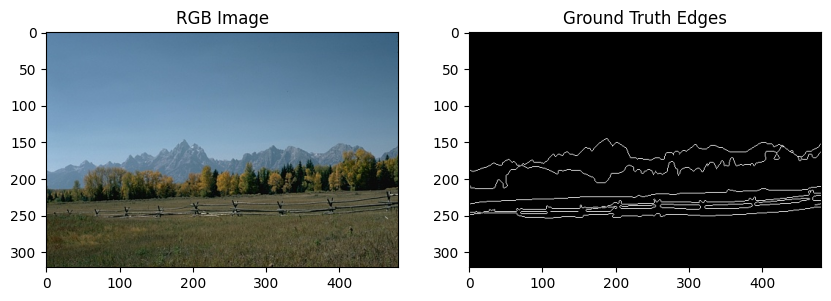

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# pick one training sample
img_path = "data/images/train/2092.jpg"
gt_path = "data/groundTruth/train/2092.mat"

# load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# load ground truth edges
mat = loadmat(gt_path)
# mat['groundTruth'] is a cell array (list of dicts)
edges_list = mat['groundTruth'][0]
# Extract the first annotator
gt_struct = edges_list[0][0, 0]  # access the MATLAB struct
# Safe access by field name
edge_map = gt_struct['Boundaries']  # binary edge mask
edge_map = edge_map.astype(np.float32)

# visualize
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("RGB Image")

plt.subplot(1,2,2)
plt.imshow(edge_map, cmap='gray')
plt.title("Ground Truth Edges")
plt.show()

In [15]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.io import loadmat
from PIL import Image
import torch
import random
import os

class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, split='train', size=(320, 320)):
        """
        root_dir: path to 'data' folder (containing images/ and groundTruth/)
        split: 'train', 'val', or 'test'
        """
        self.img_dir = os.path.join(root_dir, 'images', split)
        self.gt_dir = os.path.join(root_dir, 'groundTruth', split)
        self.size = size

        self.image_files = sorted([
            f for f in os.listdir(self.img_dir) if f.endswith('.jpg')
        ])

        self.to_tensor = transforms.ToTensor()
        self.resize = transforms.Resize(size, interpolation=Image.BILINEAR)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        gt_path = os.path.join(self.gt_dir, img_name.replace('.jpg', '.mat'))

        # --- load RGB image
        img = Image.open(img_path).convert('RGB')
        img = self.resize(img)
        img = self.to_tensor(img)

        # --- load ground truth edge map
        mat = loadmat(gt_path)
        edges_list = mat['groundTruth'][0]
        gt_struct = edges_list[0][0, 0]
        edge_map = gt_struct['Boundaries']
        edge = Image.fromarray((edge_map * 255).astype('uint8')).convert('L')
        edge = self.resize(edge)
        edge = self.to_tensor(edge)
        edge = (edge > 0.2).float()  # binarize

        # --- optional flip for augmentation
        if random.random() < 0.5:
            img = torch.flip(img, dims=[2])  # horizontal
            edge = torch.flip(edge, dims=[2])

        return img, edge

torch.Size([3, 320, 320]) torch.Size([1, 320, 320])


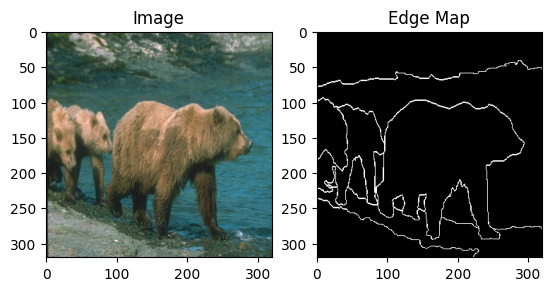

In [16]:
dataset = BSDS500Dataset(root_dir='data', split='train')
img, edge = dataset[0]
print(img.shape, edge.shape)
plt.subplot(1,2,1); plt.imshow(img.permute(1,2,0)); plt.title('Image')
plt.subplot(1,2,2); plt.imshow(edge[0], cmap='gray'); plt.title('Edge Map')
plt.show()

Test training

In [17]:
from torch.utils.data import DataLoader
import torch.optim as optim

# --- Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 2
lr = 1e-4
epochs = 1  # for now, just test one epoch
phi = 1.0   # KL weighting

# --- DataLoader
train_dataset = BSDS500Dataset(root_dir='data', split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# --- Move models to device
model_Eh.to(device)
model_MIX.to(device)
decoder.to(device)

# --- Optimizer (we'll only train decoder + Eh for now)
params = list(model_Eh.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=lr)

# --- Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for i, (imgs, edges) in enumerate(train_loader):
        imgs, edges = imgs.to(device), edges.to(device)

        optimizer.zero_grad()

        # forward
        f_high = model_Eh(imgs)
        g_global, g_local = model_MIX(imgs)
        mu, sigma2, edge_logits = decoder(f_high[1], g_local[-1])

        # compute loss
        elbo, wce, kl = elbo_loss(mu, sigma2, edges, phi=phi)
        elbo.backward()
        optimizer.step()

        running_loss += elbo.item()

        if (i+1) % 5 == 0:
            print(f"[Epoch {epoch+1}] Step {i+1}/{len(train_loader)} - "
                  f"ELBO: {elbo.item():.4f}, WCE: {wce.item():.4f}, KL: {kl.item():.4f}")

        if i == 9:  # stop early after 10 batches
            break

    print(f"Epoch {epoch+1} done. Avg loss over 10 batches: {running_loss/10:.4f}")

[Epoch 1] Step 5/100 - ELBO: 0.9268, WCE: 0.8423, KL: 0.0846
[Epoch 1] Step 10/100 - ELBO: 0.8676, WCE: 0.7997, KL: 0.0679
Epoch 1 done. Avg loss over 10 batches: 0.9176


In [ ]:
Visualize predicted edge maps during training

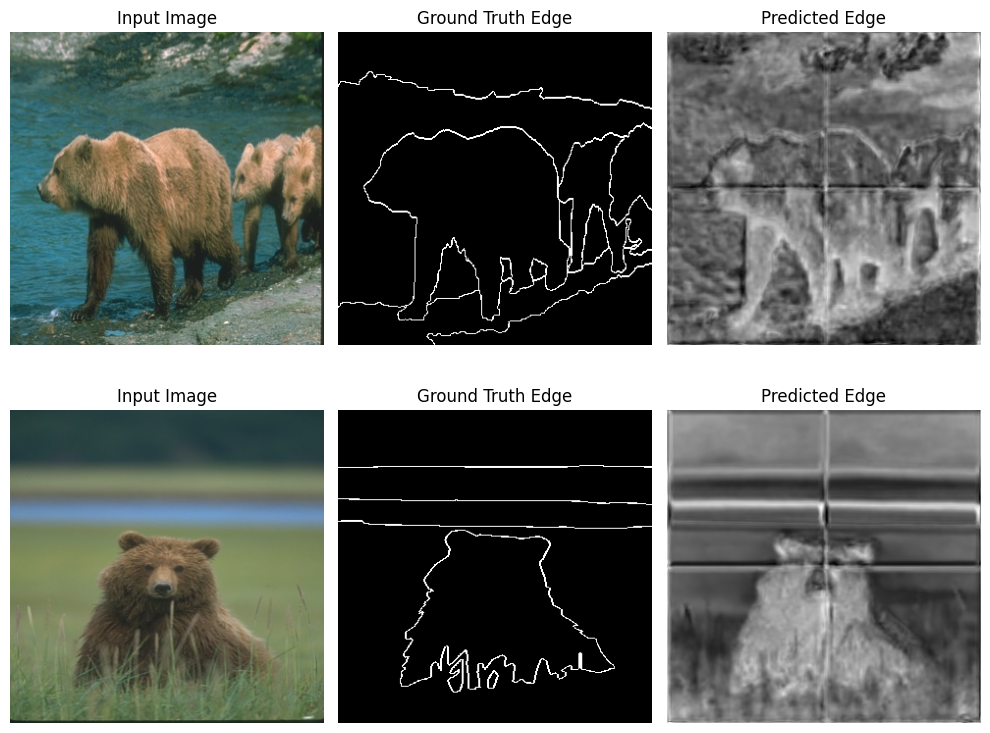

In [18]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_predictions(model_Eh, model_MIX, decoder, dataset, num_samples=2):
    model_Eh.eval()
    model_MIX.eval()
    decoder.eval()

    plt.figure(figsize=(10, 4 * num_samples))

    for i in range(num_samples):
        img, edge_gt = dataset[i]
        img = img.unsqueeze(0).to(device)
        edge_gt = edge_gt.squeeze().cpu().numpy()

        with torch.no_grad():
            f_high = model_Eh(img)
            g_global, g_local = model_MIX(img)
            mu, sigma2, edge_logits = decoder(f_high[1], g_local[-1])
            pred = torch.sigmoid(edge_logits).squeeze().cpu().numpy()

        # Display
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(img[0].permute(1, 2, 0).cpu())
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(edge_gt, cmap='gray')
        plt.title("Ground Truth Edge")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Predicted Edge")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization on a few samples
visualize_predictions(model_Eh, model_MIX, decoder, train_dataset, num_samples=2)

In [ ]:
Multi-Granularity Edge Generation

In [19]:
def generate_multigranularity_edges(mu, sigma2, gammas=[-2, 0, 2]):
    """
    Generate edge maps for multiple γ values.
    mu, sigma2: model outputs (B,1,H,W)
    gammas: list of γ multipliers
    Returns: dict {γ: edge_map}
    """
    edges = {}
    for g in gammas:
        p = mu + g * torch.sqrt(sigma2 + 1e-6)
        p = torch.sigmoid(p)
        edges[g] = p.squeeze().cpu().numpy()
    return edges

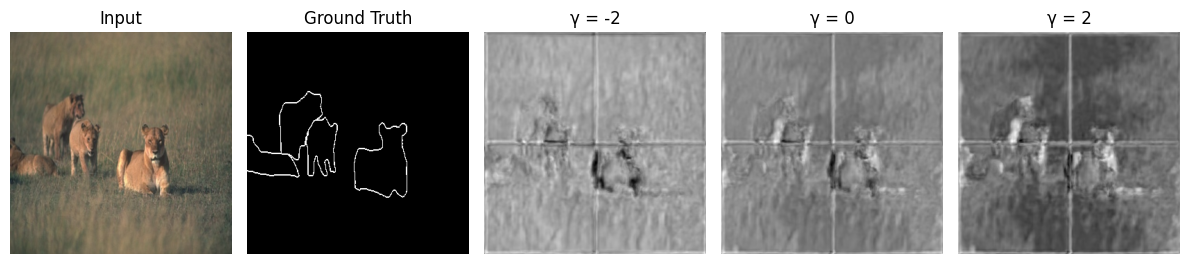

In [23]:
def visualize_multigranularity(model_Eh, model_MIX, decoder, dataset, gammas=[-2, 0, 2]):
    model_Eh.eval()
    model_MIX.eval()
    decoder.eval()

    img, edge_gt = dataset[6]  # pick one example
    img_in = img.unsqueeze(0).to(device)

    with torch.no_grad():
        f_high = model_Eh(img_in)
        g_global, g_local = model_MIX(img_in)
        mu, sigma2, edge_logits = decoder(f_high[1], g_local[-1])
        multi_edges = generate_multigranularity_edges(mu, sigma2, gammas)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, len(gammas)+2, 1)
    plt.imshow(img.permute(1,2,0))
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1, len(gammas)+2, 2)
    plt.imshow(edge_gt.squeeze(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    for j, g in enumerate(gammas):
        plt.subplot(1, len(gammas)+2, j+3)
        plt.imshow(multi_edges[g], cmap="gray")
        plt.title(f"γ = {g}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# run visualization
visualize_multigranularity(model_Eh, model_MIX, decoder, train_dataset, gammas=[-2, 0, 2])

Implementing the results of the paper

In [33]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [35]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found
